<a href="https://colab.research.google.com/github/Afra107/Epileptic-Seizure-Detection-with-ML-Classifiers/blob/main/ML_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing the libraries

In [ ]:
!pip install numpy

In [ ]:
!pip install scipy

In [ ]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.6 MB/s eta 0:00:00


In [ ]:
!pip install antropy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.1 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16877 sha256=7908539cc73cd594e2abaa3510dc75d45f25919af8820ee13e3a914aa7cc63fe
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy


In [ ]:
!pip install pyentrp

In [ ]:
!pip install nolds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 4.6 MB/s eta 0:00:00


#Loading the data

In [ ]:
import zipfile
with zipfile.ZipFile('/content/Z.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import zipfile
with zipfile.ZipFile('/content/F.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [ ]:
import zipfile
with zipfile.ZipFile('/content/S.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

#Importing the Libraries

In [ ]:
from scipy.signal import butter, filtfilt
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import os
import pandas as pd
import seaborn as sns

#Function for a bandpass filter

In [ ]:
from scipy.signal import butter, filtfilt
import numpy as np

# Define the band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

#Plotting the first frame of each set normal, interictal and seizure

In [ ]:
def plot_firstframe_signal(filepath):
  data = np.loadtxt(filepath)
  data = data[:-1]  # Remove last point (if needed)
  filtered = bandpass_filter(data, 0.53, 40.0, 173.61, 2)
  plt.figure(figsize=(4, 1))
  plt.plot(filtered[:256])
  plt.xlabel("samples")
  plt.ylabel("magnitude")
  plt.show()

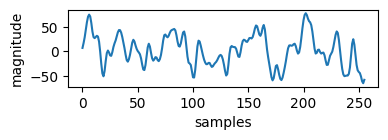

In [ ]:
#first frame of filtered eeg from set Z(normal)
plot_firstframe_signal('/content/Z001.txt')

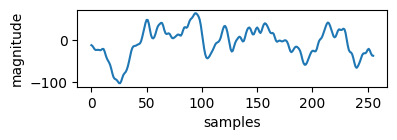

In [ ]:
#first frame of filtered eeg from set F(Epileptic/interictal)
plot_firstframe_signal('/content/F001.txt')

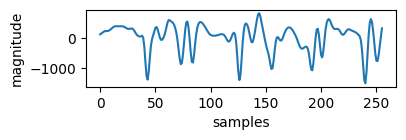

In [ ]:
#first frame of filtered eeg from set S(Seizure)
plot_firstframe_signal('/content/S001.txt')

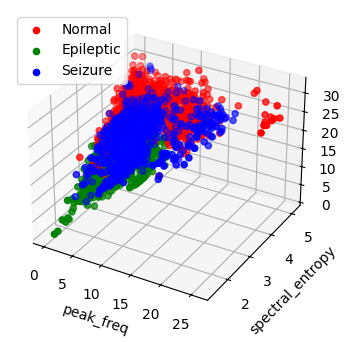

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/FD_train.csv')  # Replace with the actual path

# Extract columns
spectral_entropy = df['peak_freq']
peak_freq = df['spectral_entropy']
additional_feature = df['bandwidth']  # Replace with the name of the third feature
labels = df['label']  # Assuming your labels are in a column called 'label'

# Create a 3D scatter plot
fig = plt.figure(figsize=(4, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each class with different colors
ax.scatter(
    spectral_entropy[labels == 0],
    peak_freq[labels == 0],
    additional_feature[labels == 0],
    color='r', label='Normal'
)
ax.scatter(
    spectral_entropy[labels == 1],
    peak_freq[labels == 1],
    additional_feature[labels == 1],
    color='g', label='Epileptic'
)
ax.scatter(
    spectral_entropy[labels == 2],
    peak_freq[labels == 2],
    additional_feature[labels == 2],
    color='b', label='Seizure'
)

# Label axes
ax.set_xlabel('peak_freq')
ax.set_ylabel('spectral_entropy')
ax.set_zlabel('bandwidth')

# Add legend
ax.legend()

# Show plot
plt.show()


#Function for discrete wavelet transform on 4 levels and daubechies wavelets of order 2

In [ ]:
# Function to calculate DWT for each frame of 256 points
def compute_dwt_for_frames(data, frame_size=256, wavelet='db2', levels=4):
    num_frames = len(data) // frame_size
    approximation_coeffs = []
    detail_coeffs = []

    # Loop through each frame of the data
    for i in range(num_frames):
        # Extract the current frame (256 points)
        frame = data[i * frame_size : (i + 1) * frame_size]

        # Perform DWT on the current frame
        coeffs = pywt.wavedec(frame, wavelet, mode='periodization', level=levels)


        approximation_coeffs.append(coeffs[0])
        detail_coeffs.append(coeffs[1:])

    return approximation_coeffs, detail_coeffs

In [ ]:
# Function to plot the first approximation and detail coefficients of the first frame
def plot_dwt_coeffs(approx_coeffs, detail_coeffs, frame_index=0):
    # Get the approximation and detail coefficients for the first frame
    approx = approx_coeffs[frame_index]
    details = detail_coeffs[frame_index]

    # Create the plot
    fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
    axes[0].plot(approx)
    axes[0].set_title(f"Approximation Coefficients (Frame {frame_index+1})")

    # Plot each level of detail coefficients
    for i, detail in enumerate(details):
        axes[i+1].plot(detail)
        axes[i+1].set_title(f"Detail Coefficients - Level {i+1} (Frame {frame_index+1})")

    plt.tight_layout()
    plt.show()

#Plotting D3 coeffiecients from DWT of set Z(normal), F(Epeliptic/interictal), S(seizure)

In [ ]:
def plot_firstframe_D3(filepath):
  data = np.loadtxt(filepath)
  data = data[:-1]  # Remove last point (if needed)
  filtered = bandpass_filter(data, 0.53, 40.0, 173.61, 2)
  approx_coeffs, detail_coeffs = compute_dwt_for_frames(filtered)
  plt.figure(figsize=(4, 1))
  plt.plot(detail_coeffs[0][1])
  plt.title('number')
  plt.xlabel('coefficients index')
  plt.ylabel('magnitude')
  plt.show()

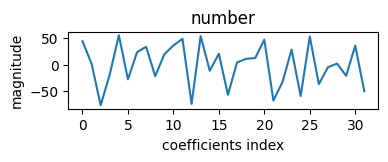

In [ ]:
#first frame of filtered eeg from set A(normal)
plot_firstframe_D3('/content/Z001.txt')

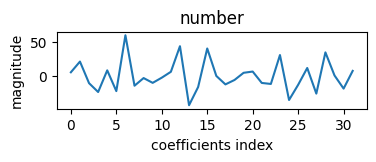

In [ ]:
#first frame of filtered eeg from set F(Epileptic/interictal)
plot_firstframe_D3('/content/F001.txt')

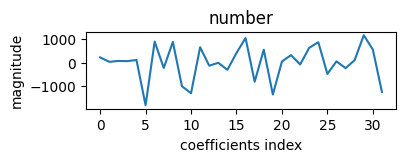

In [ ]:
#first frame of filtered eeg from set S(seizure)
plot_firstframe_D3('/content/S001.txt')

In [ ]:

def construct_dataset_set_DWT(approx_coeffs, detail_coeffs, frame = 10):

  Training_database = {}
  A4_max = []
  A4_min = []
  A4_mean = []
  A4_std = []
  A4_entropy = []
  A4_shanon_ent = []
  A4_energy = []
  A4_median = []
  A4_skewness = []
  A4_kurtosis = []
  A4_linelen = []

  D4_max = []
  D4_min = []
  D4_mean = []
  D4_std = []
  D4_entropy = []
  D4_shanon_ent = []
  D4_energy = []
  D4_median = []
  D4_skewness = []
  D4_kurtosis = []
  D4_linelen = []

  D3_max = []
  D3_min = []
  D3_mean = []
  D3_std = []
  D3_entropy = []
  D3_shanon_ent = []
  D3_energy = []
  D3_median = []
  D3_skewness = []
  D3_kurtosis = []
  D3_linelen = []


  D2_max = []
  D2_min = []
  D2_mean = []
  D2_std = []
  D2_entropy = []
  D2_shanon_ent = []
  D2_energy = []
  D2_median = []
  D2_skewness = []
  D2_kurtosis = []
  D2_linelen = []



  D1_max = []
  D1_min = []
  D1_mean = []
  D1_std = []
  D1_entropy = []
  D1_shanon_ent = []
  D1_energy = []
  D1_median = []
  D1_skewness = []
  D1_kurtosis = []
  D1_linelen = []

  for i in range(frame):

    approx = approx_coeffs[i]
    detail = detail_coeffs[i]
    approx = np.array(approx)
    d4 = np.array(detail[0])
    d3 = np.array(detail[1])
    d2 = np.array(detail[2])
    d1 = np.array(detail[3])

    #Statistic Features of A4 coeffs
    A4_max.append(np.max(approx))
    A4_min.append(np.min(approx))
    A4_mean.append(np.mean(approx))
    A4_std.append(np.std(approx))
    A4_kurtosis.append(kurtosis(a=approx))
    A4_skewness.append(skew(a=approx))
    A4_median.append(np.median(approx))
    #Calculate the entropy of A4 coeffs
    squared_coeffs = approx ** 2
    entropy = np.sum(squared_coeffs * np.log(squared_coeffs))
    A4_entropy.append(entropy)
    #Calculate the shannon entropy of A4 coeffs
    total_sum = np.sum(squared_coeffs)
    probabilities = squared_coeffs / total_sum
    # Step 3: Apply the Shannon entropy formula: H(X) = - sum(p_i * log2(p_i))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    A4_shanon_ent.append(entropy)

    #Calculate the energy of A4 coeffs
    energy = np.sum(squared_coeffs)
    A4_energy.append(energy)
    #Calculate the line length of A4
    line_length = np.sum(np.abs(np.diff(approx)))
    A4_linelen.append(line_length)




    #Statistic Features of D4 coeffs
    D4_max.append(np.max(d4))
    D4_min.append(np.min(d4))
    D4_mean.append(np.mean(d4))
    D4_std.append(np.std(d4))
    D4_kurtosis.append(kurtosis(a=d4))
    D4_skewness.append(skew(a=d4))
    D4_median.append(np.median(d4))
    #Calculate the entropy of D4 coeffs
    squared_coeffs = d4 ** 2
    entropy = np.sum(squared_coeffs * np.log(squared_coeffs))
    D4_entropy.append(entropy)
    #Calculate the shannon entropy of D4 coeffs
    total_sum = np.sum(squared_coeffs)
    probabilities = squared_coeffs / total_sum
    # Step 3: Apply the Shannon entropy formula: H(X) = - sum(p_i * log2(p_i))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    D4_shanon_ent.append(entropy)

    #Calculate the energy of D4 coeffs
    energy = np.sum(squared_coeffs)
    D4_energy.append(energy)
    #Calculate the line length of D4
    line_length = np.sum(np.abs(np.diff(d4)))
    D4_linelen.append(line_length)



    #Statistic Features of D3 coeffs
    D3_max.append(np.max(d3))
    D3_min.append(np.min(d3))
    D3_mean.append(np.mean(d3))
    D3_std.append(np.std(d3))
    D3_kurtosis.append(kurtosis(a=d3))
    D3_skewness.append(skew(a=d3))
    D3_median.append(np.median(d3))
    #Calculate the entropy of D3 coeffs
    squared_coeffs = d3 ** 2
    entropy = np.sum(squared_coeffs * np.log(squared_coeffs))
    D3_entropy.append(entropy)
    #Calculate the shannon entropy of D3 coeffs
    total_sum = np.sum(squared_coeffs)
    probabilities = squared_coeffs / total_sum
    # Step 3: Apply the Shannon entropy formula: H(X) = - sum(p_i * log2(p_i))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    D3_shanon_ent.append(entropy)

    #Calculate the energy of D3 coeffs
    energy = np.sum(squared_coeffs)
    D3_energy.append(energy)
    #Calculate the line length of D3
    line_length = np.sum(np.abs(np.diff(d3)))
    D3_linelen.append(line_length)


    #Statistic Features of D3 coeffs
    D2_max.append(np.max(d2))
    D2_min.append(np.min(d2))
    D2_mean.append(np.mean(d2))
    D2_std.append(np.std(d2))
    D2_kurtosis.append(kurtosis(a=d2))
    D2_skewness.append(skew(a=d2))
    D2_median.append(np.median(d2))
    #Calculate the entropy of D3 coeffs
    squared_coeffs = d2 ** 2
    entropy = np.sum(squared_coeffs * np.log(squared_coeffs))
    D2_entropy.append(entropy)
    #Calculate the shannon entropy of D3 coeffs
    total_sum = np.sum(squared_coeffs)
    probabilities = squared_coeffs / total_sum
    # Step 3: Apply the Shannon entropy formula: H(X) = - sum(p_i * log2(p_i))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    D2_shanon_ent.append(entropy)

    #Calculate the energy of D3 coeffs
    energy = np.sum(squared_coeffs)
    D2_energy.append(energy)
    #Calculate the line length of D3
    line_length = np.sum(np.abs(np.diff(d2)))
    D2_linelen.append(line_length)


    #Statistic Features of D3 coeffs
    D1_max.append(np.max(d1))
    D1_min.append(np.min(d1))
    D1_mean.append(np.mean(d1))
    D1_std.append(np.std(d1))
    D1_kurtosis.append(kurtosis(a=d1))
    D1_skewness.append(skew(a=d1))
    D1_median.append(np.median(d1))
    #Calculate the entropy of D3 coeffs
    squared_coeffs = d1 ** 2
    entropy = np.sum(squared_coeffs * np.log(squared_coeffs))
    D1_entropy.append(entropy)
    #Calculate the shannon entropy of D3 coeffs
    total_sum = np.sum(squared_coeffs)
    probabilities = squared_coeffs / total_sum
    # Step 3: Apply the Shannon entropy formula: H(X) = - sum(p_i * log2(p_i))
    entropy = -np.sum(probabilities * np.log2(probabilities))
    D1_shanon_ent.append(entropy)

    #Calculate the energy of D3 coeffs
    energy = np.sum(squared_coeffs)
    D1_energy.append(energy)
    #Calculate the line length of D3
    line_length = np.sum(np.abs(np.diff(d1)))
    D1_linelen.append(line_length)



    # Store features in the Training database dictionary
    Training_database['A4_max'] = A4_max
    Training_database['A4_min'] = A4_min
    Training_database['A4_mean'] = A4_mean
    Training_database['A4_std'] = A4_std
    Training_database['A4_entropy'] = A4_entropy
    Training_database['A4_shanon_ent'] = A4_shanon_ent
    Training_database['A4_energy'] = A4_energy
    Training_database['A4_median'] = A4_median
    Training_database['A4_skewness'] = A4_skewness
    Training_database['A4_kurtosis'] = A4_kurtosis
    Training_database['A4_linelen'] = A4_linelen

    # Store features in the Training database dictionary
    Training_database['D4_max'] = D4_max
    Training_database['D4_min'] = D4_min
    Training_database['D4_mean'] = D4_mean
    Training_database['D4_std'] = D4_std
    Training_database['D4_entropy'] = D4_entropy
    Training_database['D4_shanon_ent'] = D4_shanon_ent
    Training_database['D4_energy'] = D4_energy
    Training_database['D4_median'] = D4_median
    Training_database['D4_skewness'] = D4_skewness
    Training_database['D4_kurtosis'] = D4_kurtosis
    Training_database['D4_linelen'] = D4_linelen


    # Store features in the Training database dictionary
    Training_database['D3_max'] = D3_max
    Training_database['D3_min'] = D3_min
    Training_database['D3_mean'] = D3_mean
    Training_database['D3_std'] = D3_std
    Training_database['D3_entropy'] = D3_entropy
    Training_database['D3_shanon_ent'] = D3_shanon_ent
    Training_database['D3_energy'] = D3_energy
    Training_database['D3_median'] = D3_median
    Training_database['D3_skewness'] = D3_skewness
    Training_database['D3_kurtosis'] = D3_kurtosis
    Training_database['D3_linelen'] = D3_linelen


    # Store features in the Training database dictionary
    Training_database['D2_max'] = D2_max
    Training_database['D2_min'] = D2_min
    Training_database['D2_mean'] = D2_mean
    Training_database['D2_std'] = D2_std
    Training_database['D2_entropy'] = D2_entropy
    Training_database['D2_shanon_ent'] = D2_shanon_ent
    Training_database['D2_energy'] = D2_energy
    Training_database['D2_median'] = D2_median
    Training_database['D2_skewness'] = D2_skewness
    Training_database['D2_kurtosis'] = D2_kurtosis
    Training_database['D2_linelen'] = D2_linelen


    # Store features in the Training database dictionary
    Training_database['D1_max'] = D1_max
    Training_database['D1_min'] = D1_min
    Training_database['D1_mean'] = D1_mean
    Training_database['D1_std'] = D1_std
    Training_database['D1_entropy'] = D1_entropy
    Training_database['D1_shanon_ent'] = D1_shanon_ent
    Training_database['D1_energy'] = D1_energy
    Training_database['D1_median'] = D1_median
    Training_database['D1_skewness'] = D1_skewness
    Training_database['D1_kurtosis'] = D1_kurtosis
    Training_database['D1_linelen'] = D1_linelen
    # Training_database['label'] = label

  return Training_database


In [ ]:
def process_files_with_labels_DWT(file_ranges, frame_size=256, wavelet='db2', levels=4,
                              lowcut=0.53, highcut=40.0, fs=173.61, order=2):
    """
    Processes EEG data files from specified prefixes, computes features,
    and assigns labels based on the prefix.

    Args:
    - file_ranges: List of tuples (prefix, range, label).
                   Example: [('Z', 100, 0), ('F', 100, 1), ('S', 100, 2)]
    - frame_size: Size of each frame for DWT.
    - wavelet: Wavelet type for DWT.
    - levels: Number of decomposition levels for DWT.
    - lowcut, highcut: Bandpass filter cutoff frequencies.
    - fs: Sampling frequency of the EEG data.
    - order: Order of the bandpass filter.

    Returns:
    - train_df: DataFrame containing training data with labels.
    - test_df: DataFrame containing testing data with labels.
    """
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for prefix, file_range, label in file_ranges:
        for i in range(1, file_range + 1):
            file_name = f"{prefix}{str(i).zfill(3)}.txt"
            file_path = os.path.join("/content", file_name)  # Adjust this path as needed

            if os.path.exists(file_path):
                print(f"Processing {file_name}...")

                # Load EEG data
                data = np.loadtxt(file_path)
                data = data[:-1]  # Remove last point (if needed)

                # Apply the bandpass filter
                filtered_data = bandpass_filter(data, lowcut, highcut, fs, order)

                # Compute the DWT of the filtered data
                approx_coeffs, detail_coeffs = compute_dwt_for_frames(
                    filtered_data, frame_size=frame_size, wavelet=wavelet, levels=levels
                )

                # Separate into training and testing frames
                train_approx_frames = approx_coeffs[:10]
                train_detail_frames = detail_coeffs[:10]
                test_approx_frames = approx_coeffs[10:]
                test_detail_frames = detail_coeffs[10:]

                # Create feature databases for train and test
                train_database = construct_dataset_set_DWT(train_approx_frames, train_detail_frames, frame = 10)
                test_database = construct_dataset_set_DWT(test_approx_frames, test_detail_frames, frame =6)

                # Add label to the data
                train_database["label"] = [label] * len(train_database["A4_max"])
                test_database["label"] = [label] * len(test_database["A4_max"])

                # Convert to DataFrames and append
                df_train = pd.DataFrame.from_dict(train_database)
                train_df = pd.concat([train_df, df_train], ignore_index=True)
                df_test = pd.DataFrame.from_dict(test_database)
                test_df = pd.concat([test_df, df_test], ignore_index=True)

                print(f"File: {file_name}, Processed frames: {len(approx_coeffs)}")
            else:
                print(f"File {file_name} does not exist.")

    return train_df, test_df


# Example usage:
file_ranges = [
    ('Z', 100, 0),  # Prefix 'Z', 100 files, label 0
    ('F', 100, 1),  # Prefix 'F', 100 files, label 1
    ('S', 100, 2)   # Prefix 'S', 100 files, label 2
]

TFDF_train, TFDF_test = process_files_with_labels_DWT(file_ranges=file_ranges)

Processing Z001.txt...
File: Z001.txt, Processed frames: 16
Processing Z002.txt...
File: Z002.txt, Processed frames: 16
Processing Z003.txt...
File: Z003.txt, Processed frames: 16
Processing Z004.txt...
File: Z004.txt, Processed frames: 16
Processing Z005.txt...
File: Z005.txt, Processed frames: 16
Processing Z006.txt...
File: Z006.txt, Processed frames: 16
Processing Z007.txt...
File: Z007.txt, Processed frames: 16
Processing Z008.txt...
File: Z008.txt, Processed frames: 16
Processing Z009.txt...
File: Z009.txt, Processed frames: 16
Processing Z010.txt...
File: Z010.txt, Processed frames: 16
Processing Z011.txt...
File: Z011.txt, Processed frames: 16
Processing Z012.txt...
File: Z012.txt, Processed frames: 16
Processing Z013.txt...
File: Z013.txt, Processed frames: 16
Processing Z014.txt...
File: Z014.txt, Processed frames: 16
Processing Z015.txt...
File: Z015.txt, Processed frames: 16
Processing Z016.txt...
File: Z016.txt, Processed frames: 16
Processing Z017.txt...
File: Z017.txt, P

In [ ]:
TFDF_train.head()

,A4_max,A4_min,A4_mean,A4_std,A4_entropy,A4_shanon_ent,A4_energy,A4_median,A4_skewness,A4_kurtosis,...,D1_mean,D1_std,D1_entropy,D1_shanon_ent,D1_energy,D1_median,D1_skewness,D1_kurtosis,D1_linelen,label
0,181.622837,-105.785638,8.914920,85.196465,1.120610e+06,3.071070,117406.615956,-5.854204,0.614804,-0.666750,...,-0.148117,4.430934,11321.623311,4.804546,2515.854493,0.240947,-2.115557,13.247814,551.541958,0
1,214.373658,-167.562928,5.095440,94.040621,1.406938e+06,2.811706,141913.630168,17.112377,0.020622,-0.016488,...,0.166418,4.932341,13154.269951,5.518797,3117.527114,0.371278,0.696273,3.002729,672.522196,0
2,194.427132,-346.952932,-15.577652,113.593444,2.265492e+06,2.143496,210338.138795,-18.180049,-1.049871,2.448215,...,-0.020181,4.560397,9646.824298,6.150352,2662.096163,-0.032004,0.094397,-0.662931,623.998850,0
3,140.338550,-140.945378,17.746638,90.221631,1.267979e+06,3.523013,135278.175190,36.206605,-0.266069,-1.296367,...,0.134620,4.599999,11108.171500,5.492701,2710.798851,0.108489,0.999141,4.243815,588.878710,0
4,146.177686,-164.593335,-7.240963,95.478642,1.402837e+06,3.366309,146697.641546,-28.711226,0.255304,-1.106615,...,-0.281844,6.387329,29643.249633,4.179750,5232.307718,-0.208481,-3.560976,26.107799,698.229554,0


In [ ]:
print(len(TFDF_train.index))
print(len(TFDF_test.index))

3000
1800


In [ ]:
from scipy.signal import welch
from scipy.integrate import simps

# Function to compute PSD and extract features
def extract_psd_features(data, frame_size=256, fs=173.61, freq_bands=[(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 40)]):
    """
    Parameters:
    - data: The EEG signal.
    - frame_size: Number of points per frame.
    - fs: Sampling frequency.
    - freq_bands: List of frequency bands for power calculation.

    Returns:
    - psd_features: A dictionary with extracted PSD features.
    """
    num_frames = len(data) // frame_size
    psd_features = {
        'energy': [],
        'intensity_weighted_mean_freq': [],
        'intensity_weighted_bandwidth': [],
        'spectral_edge_freq': [],
        'spectral_entropy': [],
        'peak_freq': [],
        'bandwidth': [],
    }

    # Initialize band-related features
    for band in freq_bands:
        band_key = f"{band[0]}-{band[1]}Hz"
        psd_features[f"{band_key} (relative power)"] = []
        psd_features[f"{band_key} (absolute power)"] = []

    for i in range(num_frames):
        # Extract current frame
        frame = data[i * frame_size:(i + 1) * frame_size]

        # Compute PSD using Welch's method
        freqs, psd = welch(frame, fs=fs, nperseg=frame_size)

        # Energy (area under PSD curve)
        energy = simps(psd, freqs)
        psd_features['energy'].append(energy)

        # Intensity-weighted mean frequency
        mean_freq = np.sum(freqs * psd) / np.sum(psd)
        psd_features['intensity_weighted_mean_freq'].append(mean_freq)

        # Intensity-weighted bandwidth
        weighted_bandwidth = np.sqrt(np.sum(psd * (freqs - mean_freq) ** 2) / np.sum(psd))
        psd_features['intensity_weighted_bandwidth'].append(weighted_bandwidth)

        # Spectral edge frequency (90% power)
        cumulative_power = np.cumsum(psd) / np.sum(psd)
        spectral_edge_freq = freqs[np.where(cumulative_power >= 0.9)[0][0]]
        psd_features['spectral_edge_freq'].append(spectral_edge_freq)

        # Spectral entropy
        normalized_psd = psd / np.sum(psd)
        spectral_entropy = -np.sum(normalized_psd * np.log2(normalized_psd + 1e-12))  # Avoid log(0)
        psd_features['spectral_entropy'].append(spectral_entropy)

        # Peak frequency (frequency with maximum power)
        peak_freq = freqs[np.argmax(psd)]
        psd_features['peak_freq'].append(peak_freq)

        # Bandwidth (frequency range containing 95% of power)
        cumulative_power_95 = freqs[np.where(cumulative_power >= 0.95)[0][0]] - freqs[0]
        psd_features['bandwidth'].append(cumulative_power_95)

        # Power in specified frequency bands
        total_power = np.sum(psd)
        for band in freq_bands:
            band_key = f"{band[0]}-{band[1]}Hz"
            band_power = np.sum(psd[(freqs >= band[0]) & (freqs < band[1])])
            psd_features[f"{band_key} (relative power)"].append(band_power / total_power)  # Relative power
            psd_features[f"{band_key} (absolute power)"].append(band_power)  # Absolute power

    return psd_features

In [ ]:
def process_files_with_labels_PSD(file_ranges, frame_size=256, wavelet='db2', levels=4,
                              lowcut=0.53, highcut=40.0, fs=173.61, order=2):
    """
    Processes EEG data files from specified prefixes, computes features,
    and assigns labels based on the prefix.

    Args:
    - file_ranges: List of tuples (prefix, range, label).
                   Example: [('Z', 100, 0), ('F', 100, 1), ('S', 100, 2)]
    - frame_size: Size of each frame for DWT.
    - wavelet: Wavelet type for DWT.
    - levels: Number of decomposition levels for DWT.
    - lowcut, highcut: Bandpass filter cutoff frequencies.
    - fs: Sampling frequency of the EEG data.
    - order: Order of the bandpass filter.

    Returns:
    - train_df: DataFrame containing training data with labels.
    - test_df: DataFrame containing testing data with labels.
    """
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for prefix, file_range, label in file_ranges:
        for i in range(1, file_range + 1):
            file_name = f"{prefix}{str(i).zfill(3)}.txt"
            file_path = os.path.join("/content", file_name)  # Adjust this path as needed

            if os.path.exists(file_path):
                print(f"Processing {file_name}...")

                # Load EEG data
                data = np.loadtxt(file_path)
                data = data[:-1]  # Remove last point (if needed)

                # Apply the bandpass filter
                filtered_data = bandpass_filter(data, lowcut, highcut, fs, order)
                #Function to extract the frequency domain features
                psd_features = extract_psd_features(filtered_data)


                # Add label to the data
                psd_features["label"] = [label] * len(psd_features["energy"])
                # test_database["label"] = [label] * len(test_database["energy"])

                # Convert to DataFrames and append
                df = pd.DataFrame.from_dict(psd_features)
                train_df = pd.concat([train_df, df.iloc[0:10]], ignore_index=True)
                test_df = pd.concat([test_df, df.iloc[10:16]], ignore_index=True)

                print(f"File: {file_name}")
            else:
                print(f"File {file_name} does not exist.")

    return train_df, test_df


# Example usage:
file_ranges = [
    ('Z', 100, 0),  # Prefix 'Z', 100 files, label 0
    ('F', 100, 1),  # Prefix 'F', 100 files, label 1
    ('S', 100, 2)   # Prefix 'S', 100 files, label 2
]

FD_train, FD_test = process_files_with_labels_PSD(file_ranges=file_ranges)

Processing Z001.txt...
File: Z001.txt
Processing Z002.txt...
File: Z002.txt
Processing Z003.txt...
File: Z003.txt
Processing Z004.txt...
File: Z004.txt
Processing Z005.txt...
File: Z005.txt
Processing Z006.txt...
File: Z006.txt
Processing Z007.txt...
File: Z007.txt
Processing Z008.txt...
File: Z008.txt
Processing Z009.txt...
File: Z009.txt
Processing Z010.txt...
File: Z010.txt
Processing Z011.txt...
File: Z011.txt
Processing Z012.txt...
File: Z012.txt
Processing Z013.txt...
File: Z013.txt
Processing Z014.txt...


<ipython-input-29-e3819f3d4538>:41: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  energy = simps(psd, freqs)


File: Z014.txt
Processing Z015.txt...
File: Z015.txt
Processing Z016.txt...
File: Z016.txt
Processing Z017.txt...
File: Z017.txt
Processing Z018.txt...
File: Z018.txt
Processing Z019.txt...
File: Z019.txt
Processing Z020.txt...
File: Z020.txt
Processing Z021.txt...
File: Z021.txt
Processing Z022.txt...
File: Z022.txt
Processing Z023.txt...
File: Z023.txt
Processing Z024.txt...
File: Z024.txt
Processing Z025.txt...
File: Z025.txt
Processing Z026.txt...
File: Z026.txt
Processing Z027.txt...
File: Z027.txt
Processing Z028.txt...
File: Z028.txt
Processing Z029.txt...
File: Z029.txt
Processing Z030.txt...
File: Z030.txt
Processing Z031.txt...
File: Z031.txt
Processing Z032.txt...
File: Z032.txt
Processing Z033.txt...
File: Z033.txt
Processing Z034.txt...
File: Z034.txt
Processing Z035.txt...
File: Z035.txt
Processing Z036.txt...
File: Z036.txt
Processing Z037.txt...
File: Z037.txt
Processing Z038.txt...
File: Z038.txt
Processing Z039.txt...
File: Z039.txt
Processing Z040.txt...
File: Z040.t

In [ ]:
print(len(FD_train.index))
print(len(FD_test.index))

3000
1800


In [ ]:
FD_train.head()

,energy,intensity_weighted_mean_freq,intensity_weighted_bandwidth,spectral_edge_freq,spectral_entropy,peak_freq,bandwidth,0.5-4Hz (relative power),0.5-4Hz (absolute power),4-8Hz (relative power),4-8Hz (absolute power),8-12Hz (relative power),8-12Hz (absolute power),12-30Hz (relative power),12-30Hz (absolute power),30-40Hz (relative power),30-40Hz (absolute power),label
0,824.327799,6.590557,5.934449,16.275938,4.002171,2.712656,17.632266,0.478489,605.404356,0.245944,311.178305,0.083723,105.929620,0.188420,238.396789,0.002555,3.233211,0
1,1190.782029,6.843271,6.353484,17.632266,4.195171,2.712656,20.344922,0.469397,827.084470,0.226636,399.336171,0.116848,205.888462,0.183274,322.931620,0.003447,6.074265,0
2,2942.614342,6.217812,5.275784,12.206953,4.083210,1.356328,16.954102,0.443026,1945.624113,0.145460,638.814147,0.305950,1343.631231,0.100031,439.304909,0.001531,6.723617,0
3,1397.222142,8.806822,5.567553,15.597773,4.458175,9.494297,20.344922,0.250225,521.082992,0.131962,274.804383,0.445625,927.995834,0.166270,346.250277,0.001915,3.987392,0
4,1539.172174,7.575559,5.616956,15.597773,4.255126,1.356328,20.344922,0.250873,584.767133,0.380089,885.961036,0.229739,535.506195,0.136924,319.160282,0.002185,5.093209,0


In [ ]:
psd_features = extract_psd_features(filtered_data, frame_size=256, fs=173.61)

# Convert to DataFrame
psd_features_df = pd.DataFrame(psd_features)

# Display the PSD features
print(psd_features_df.head())
psd_features_df.shape

NameError: name 'filtered_data' is not defined

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis, entropy
from scipy.signal import find_peaks
from scipy.linalg import svd
from pyentrp import entropy as ent
from nolds import hurst_rs, dfa

# Function to calculate time-domain features
def extract_time_features(data, frame_size=256):
    """
    Parameters:
    - data: The EEG signal.
    - frame_size: Number of points per frame.

    Returns:
    - time_features: A dictionary with extracted time-domain features.
    """
    num_frames = len(data) // frame_size
    time_features = {
        'mean': [],
        'variance': [],
        'mode': [],
        'median': [],
        'skewness': [],
        'kurtosis': [],
        'min': [],
        'max': [],
        'energy': [],
        'average_power': [],
        'rms': [],
        'line_length': [],
        'amplitude_integrated_eeg': [],
        'nonlinear_energy': [],
        'shannon_entropy': [],
        'approximate_entropy': [],
        'sample_entropy': [],
        'permutation_entropy': [],
        'weighted_permutation_entropy': [],
        'fuzzy_entropy': [],
        'distribution_entropy': [],
        'singular_value_decomposition': [],
        'hurst_exponent': [],
        'fractal_dimension': [],
        'hjorth_activity': [],
        'hjorth_mobility': [],
        'hjorth_complexity': [],
        'dfa': [],
        'zero_crossings': [],
        'local_extrema': []
    }

    for i in range(num_frames):
        # Extract current frame
        frame = data[i * frame_size:(i + 1) * frame_size]

        # Basic statistics
        time_features['mean'].append(np.mean(frame))
        time_features['variance'].append(np.var(frame))
        time_features['mode'].append(max(set(frame), key=frame.tolist().count))
        time_features['median'].append(np.median(frame))
        time_features['skewness'].append(skew(frame))
        time_features['kurtosis'].append(kurtosis(frame))
        time_features['min'].append(np.min(frame))
        time_features['max'].append(np.max(frame))

        # Energy-related features
        energy = np.sum(np.square(frame))
        time_features['energy'].append(energy)
        time_features['average_power'].append(energy / frame_size)
        time_features['rms'].append(np.sqrt(np.mean(np.square(frame))))

        # Signal shape features
        time_features['line_length'].append(np.sum(np.abs(np.diff(frame))))
        time_features['amplitude_integrated_eeg'].append(np.sum(np.abs(frame)))
        time_features['nonlinear_energy'].append(np.sum(frame[1:-1] ** 2 - frame[:-2] * frame[2:]))

        # Shannon entropy
        probabilities, _ = np.histogram(frame, bins=20, density=True)
        probabilities += 1e-12  # Avoid division by zero
        time_features['shannon_entropy'].append(entropy(probabilities, base=2))

        # Approximate entropy
        m = 2
        r = 0.2 * np.std(frame)
        U = frame
        x_m = np.array([U[i:i + m] for i in range(len(U) - m + 1)])
        x_m1 = np.array([U[i:i + m + 1] for i in range(len(U) - m)])
        C_m = np.sum(np.max(np.abs(x_m[:, None] - x_m[None, :]), axis=2) <= r, axis=0) / (len(U) - m + 1)
        C_m1 = np.sum(np.max(np.abs(x_m1[:, None] - x_m1[None, :]), axis=2) <= r, axis=0) / (len(U) - m)
        time_features['approximate_entropy'].append(np.mean(np.log(C_m + 1e-12)) - np.mean(np.log(C_m1 + 1e-12)))

        # Sample entropy
        B = np.sum(np.sum(np.max(np.abs(x_m[:, None] - x_m[None, :]), axis=2) <= r, axis=0) - 1)  # Exclude self-matches
        A = np.sum(np.sum(np.max(np.abs(x_m1[:, None] - x_m1[None, :]), axis=2) <= r, axis=0) - 1)  # Exclude self-matches
        N = len(U)
        sample_entropy = -np.log((A / (N - m)) / (B / (N - m - 1)) + 1e-12)
        time_features['sample_entropy'].append(sample_entropy)

        # Permutation entropy
        time_features['permutation_entropy'].append(ent.permutation_entropy(frame, 3, 1))

        # Weighted permutation entropy
        time_features['weighted_permutation_entropy'].append(ent.weighted_permutation_entropy(frame, 3, 1))

        # Fuzzy Entropy
        phi_m = np.mean([
            np.exp(-np.linalg.norm(frame[i:i+m] - frame[j:j+m], ord=np.inf)**2 / (2 * r**2))
            for i in range(N - m) for j in range(N - m) if i != j
        ])
        phi_m1 = np.mean([
            np.exp(-np.linalg.norm(frame[i:i+m+1] - frame[j:j+m+1], ord=np.inf)**2 / (2 * r**2))
            for i in range(N - m - 1) for j in range(N - m - 1) if i != j
        ])
        time_features['fuzzy_entropy'].append(np.log(phi_m + 1e-12) - np.log(phi_m1 + 1e-12))

        # Distribution entropy
        B = 3  # Number of bins
        probabilities, _ = np.histogram(frame, bins=B, density=False)
        probabilities = probabilities / np.sum(probabilities)  # Convert to relative frequencies
        probabilities += 1e-12
        time_features['distribution_entropy'].append(-np.sum(probabilities * np.log(probabilities)) / np.log(B))

        # Singular Value Decomposition (SVD)
        u, s, vh = svd(np.reshape(frame, (frame_size, 1)), full_matrices=False)
        time_features['singular_value_decomposition'].append(np.sum(s))

        # Fractal and complexity measures
        time_features['hurst_exponent'].append(hurst_rs(frame))
        time_features['fractal_dimension'].append(ent.permutation_entropy(frame, 3, 1) / np.log2(frame_size))
        time_features['hjorth_activity'].append(np.var(frame))
        time_features['hjorth_mobility'].append(np.sqrt(np.var(np.gradient(frame))) / np.sqrt(np.var(frame)))
        time_features['hjorth_complexity'].append(
            (np.sqrt(np.var(np.gradient(np.gradient(frame))) / np.sqrt(np.var(np.gradient(frame)))) /
             (np.sqrt(np.var(np.gradient(frame))) / np.sqrt(np.var(frame))))
        )
        time_features['dfa'].append(dfa(frame))

        # Signal transitions
        time_features['zero_crossings'].append(np.sum(np.diff(np.sign(frame)) != 0))
        time_features['local_extrema'].append(len(find_peaks(frame)[0]) + len(find_peaks(-frame)[0]))

    return time_features


In [ ]:
def process_files_with_labels_TD(file_ranges, frame_size=256, wavelet='db2', levels=4,
                              lowcut=0.53, highcut=40.0, fs=173.61, order=2):
    """
    Processes EEG data files from specified prefixes, computes features,
    and assigns labels based on the prefix.

    Args:
    - file_ranges: List of tuples (prefix, range, label).
                   Example: [('Z', 100, 0), ('F', 100, 1), ('S', 100, 2)]
    - frame_size: Size of each frame for DWT.
    - wavelet: Wavelet type for DWT.
    - levels: Number of decomposition levels for DWT.
    - lowcut, highcut: Bandpass filter cutoff frequencies.
    - fs: Sampling frequency of the EEG data.
    - order: Order of the bandpass filter.

    Returns:
    - train_df: DataFrame containing training data with labels.
    - test_df: DataFrame containing testing data with labels.
    """
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for prefix, file_range, label in file_ranges:
        for i in range(1, file_range + 1):
            file_name = f"{prefix}{str(i).zfill(3)}.txt"
            file_path = os.path.join("/content", file_name)  # Adjust this path as needed

            if os.path.exists(file_path):
                print(f"Processing {file_name}...")

                # Load EEG data
                data = np.loadtxt(file_path)
                data = data[:-1]  # Remove last point (if needed)

                # Apply the bandpass filter
                filtered_data = bandpass_filter(data, lowcut, highcut, fs, order)
                # Function to extract time domain features
                time_features = extract_time_features(filtered_data)

                # Add label to the data
                time_features["label"] = [label] * len(time_features["mean"])

                # Convert to DataFrames and append
                df = pd.DataFrame.from_dict(time_features)
                train_df = pd.concat([train_df, df.iloc[0:10]], ignore_index=True)
                test_df = pd.concat([test_df, df.iloc[10:16]], ignore_index=True)

                print(f"File: {file_name}")
            else:
                print(f"File {file_name} does not exist.")

    return train_df, test_df


# Example usage:
file_ranges = [
    ('Z', 100, 0),  # Prefix 'Z', 100 files, label 0
    ('F', 100, 1),  # Prefix 'F', 100 files, label 1
    ('S', 100, 2)   # Prefix 'S', 100 files, label 2
]

TD_train, TD_test = process_files_with_labels_TD(file_ranges=file_ranges)

Processing Z001.txt...


KeyboardInterrupt: 

In [ ]:
print(len(TD_train.index))
print(len(TD_test.index))

In [ ]:
# Extract time-domain features
time_features = extract_time_features(filtered_data, frame_size=256)

# Convert to DataFrame
time_features_df = pd.DataFrame(time_features)

# Display time-domain features
print(time_features_df.head())
time_features_df.shape

In [ ]:
# Specify the file path where you want to save the CSV
file_path1 = "/content/TFDF_train.csv"
file_path2 = "/content/TFDF_test.csv"

file_path3 = "/content/FD_train.csv"
file_path4 = "/content/FD_test.csv"

file_path5 = "/content/TD_train.csv"
file_path6 = "/content/TD_test.csv"


# Convert DataFrame to CSV and save it
TFDF_train.to_csv(file_path1, index=False)
TFDF_test.to_csv(file_path2, index=False)

FD_train.to_csv(file_path3, index=False)
FD_test.to_csv(file_path4, index=False)

TD_train.to_csv(file_path5, index=False)
TD_test.to_csv(file_path6, index=False)

In [ ]:
train_all_features = pd.concat([TFDF_train.drop('label', axis = 1), FD_train.drop('label', axis =1)], axis=1)
train_all_features = pd.concat([train_all_features, TD_train], axis=1)



test_all_features = pd.concat([TFDF_test, FD_test], axis=1)
test_all_features = pd.concat([test_all_features, TD_test], axis=1)
train_all_features.head()

In [ ]:
file_path7 = "/content/train_all_features.csv"
file_path8 = "/content/test_all_features.csv"

train_all_features.to_csv(file_path7, index=False)
test_all_features.to_csv(file_path8, index = False)

NameError: name 'train_all_features' is not defined

In [ ]:
# Load the dataset
df = pd.read_csv('/content/FD_train.csv')

# Create a pair plot
sns.pairplot(df, hue='label', diag_kind='kde')

# Show the plot
plt.show()

In [ ]:
# Load the dataset
df = pd.read_csv('/content/train_all_features.csv')

# Drop columns with 'D1' or 'D2' in their names
columns_to_drop = [col for col in df.columns if 'D1' in col or 'D2' in col]
df = df.drop(columns=columns_to_drop)

# Display the updated DataFrame
print("Remaining columns:", df.columns)

Remaining columns: Index(['A4_max', 'A4_min', 'A4_mean', 'A4_std', 'A4_entropy', 'A4_shanon_ent',
       'A4_energy', 'A4_median', 'A4_skewness', 'A4_kurtosis', 'A4_linelen',
       'D4_max', 'D4_min', 'D4_mean', 'D4_std', 'D4_entropy', 'D4_shanon_ent',
       'D4_energy', 'D4_median', 'D4_skewness', 'D4_kurtosis', 'D4_linelen',
       'D3_max', 'D3_min', 'D3_mean', 'D3_std', 'D3_entropy', 'D3_shanon_ent',
       'D3_energy', 'D3_median', 'D3_skewness', 'D3_kurtosis', 'D3_linelen',
       'energy', 'intensity_weighted_mean_freq',
       'intensity_weighted_bandwidth', 'spectral_edge_freq',
       'spectral_entropy', 'peak_freq', 'bandwidth',
       '0.5-4Hz (relative power)', '0.5-4Hz (absolute power)',
       '4-8Hz (relative power)', '4-8Hz (absolute power)',
       '8-12Hz (relative power)', '8-12Hz (absolute power)',
       '12-30Hz (relative power)', '12-30Hz (absolute power)',
       '30-40Hz (relative power)', '30-40Hz (absolute power)', 'mean',
       'variance', 'mode', 'media

In [ ]:
from sklearn.feature_selection import VarianceThreshold
# Example dataset
X = df.drop('label', axis=1)
y = df['label']


threshold = 0.2
selector = VarianceThreshold(threshold=threshold)
X_selected = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()]
selected_features

Index(['A4_max', 'A4_min', 'A4_mean', 'A4_std', 'A4_entropy', 'A4_energy',
       'A4_median', 'A4_skewness', 'A4_kurtosis', 'A4_linelen', 'D4_max',
       'D4_min', 'D4_mean', 'D4_std', 'D4_entropy', 'D4_energy', 'D4_median',
       'D4_skewness', 'D4_kurtosis', 'D4_linelen', 'D3_max', 'D3_min',
       'D3_mean', 'D3_std', 'D3_entropy', 'D3_shanon_ent', 'D3_energy',
       'D3_median', 'D3_skewness', 'D3_kurtosis', 'D3_linelen', 'energy',
       'intensity_weighted_mean_freq', 'intensity_weighted_bandwidth',
       'spectral_edge_freq', 'spectral_entropy', 'peak_freq', 'bandwidth',
       '0.5-4Hz (absolute power)', '4-8Hz (absolute power)',
       '8-12Hz (absolute power)', '12-30Hz (absolute power)',
       '30-40Hz (absolute power)', 'mean', 'variance', 'mode', 'median',
       'skewness', 'kurtosis', 'min', 'max', 'energy.1', 'average_power',
       'rms', 'line_length', 'amplitude_integrated_eeg', 'nonlinear_energy',
       'singular_value_decomposition', 'hjorth_activity', 'hjor

In [ ]:
features = df[selected_features]
label_column = df['label']

data = pd.concat([features, label_column], axis=1)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

# Replace this with your dataset and labels
X = features
y = df['label']
from sklearn.preprocessing import StandardScaler

# Normalize the discriminative metrics
scaler = StandardScaler()
normalized_features = scaler.fit_transform(X)
# Initialize an empty list to store selected feature indices
selected_features = []

# Define the machine learning model (in this case, a Random Forest Classifier)
model = LogisticRegression()

# Define the number of features you want to select
num_features_to_select = 3

while len(selected_features) < num_features_to_select:
    best_score = -1
    best_feature = None

    for feature_idx in range(normalized_features.shape[1]):
        if feature_idx in selected_features:
            continue

        # Try adding the feature to the selected set
        candidate_features = selected_features + [feature_idx]

        # Evaluate the model's performance using cross-validation
        scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # Keep track of the best-performing feature
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature_idx

    if best_feature is not None:
        selected_features.append(best_feature)
        print(f"Selected Feature {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")

print("Selected feature indices:", selected_features)

Selected Feature 1: 9, Mean Accuracy: 0.7633
Selected Feature 2: 34, Mean Accuracy: 0.8993
Selected Feature 3: 54, Mean Accuracy: 0.9187
Selected feature indices: [9, 34, 54]


In [ ]:
logreg_features = []
for idx in selected_features:
  logreg_features.append(X.columns[idx])

print(logreg_features)

['A4_linelen', 'spectral_edge_freq', 'line_length']


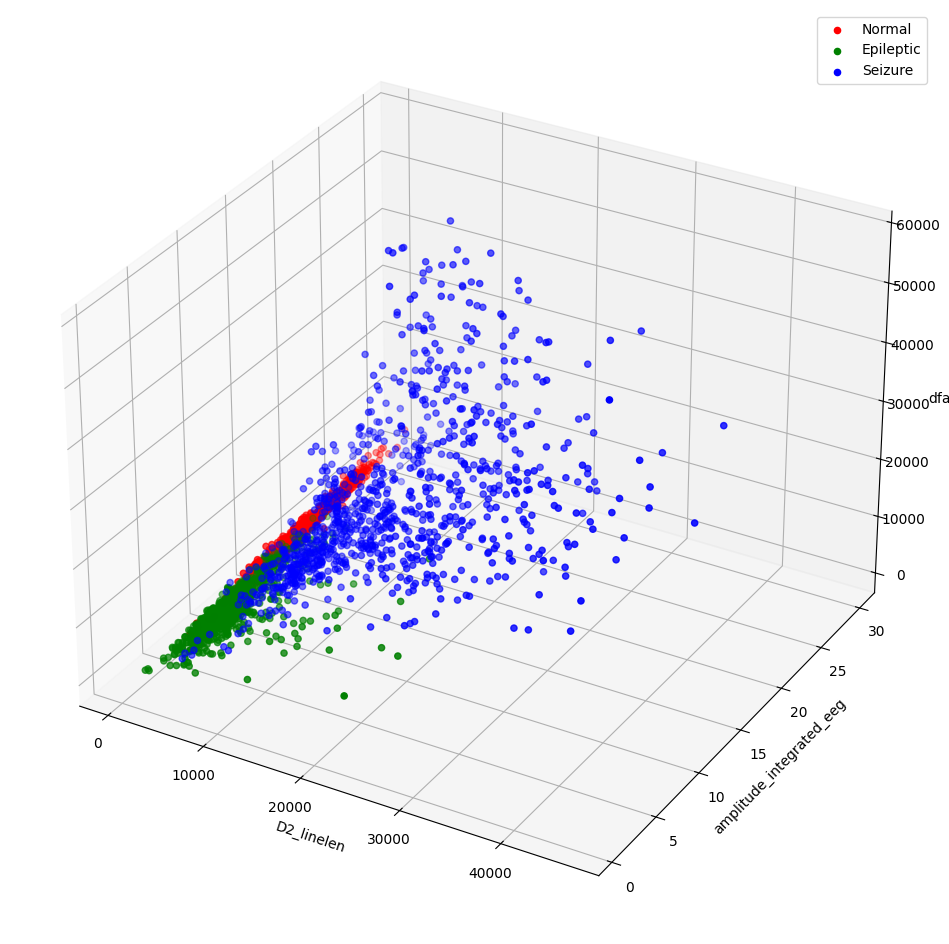

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Extract columns
spectral_entropy = df['A4_linelen']
peak_freq = df['spectral_edge_freq']
additional_feature = df['line_length']  # Replace with the name of the third feature
labels = df['label']  # Assuming your labels are in a column called 'label'

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each class with different colors
ax.scatter(
    spectral_entropy[labels == 0],
    peak_freq[labels == 0],
    additional_feature[labels == 0],
    color='r', label='Normal'
)
ax.scatter(
    spectral_entropy[labels == 1],
    peak_freq[labels == 1],
    additional_feature[labels == 1],
    color='g', label='Epileptic'
)
ax.scatter(
    spectral_entropy[labels == 2],
    peak_freq[labels == 2],
    additional_feature[labels == 2],
    color='b', label='Seizure'
)

# Label axes
ax.set_xlabel('D2_linelen')
ax.set_ylabel('amplitude_integrated_eeg')
ax.set_zlabel('dfa')

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
# Define the machine learning model (in this case, a Random Forest Classifier)
model = LogisticRegression()

X_logreg = df[logreg_features]
y = df['label']

scaler = StandardScaler()
normalized_features = scaler.fit_transform(X_logreg)

# Define the machine learning model (in this case, a Random Forest Classifier)
model = LogisticRegression()

model.fit(normalized_features, y)

LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
X_test = pd.read_csv('/content/test_all_features.csv')

x_test = X_test[logreg_features]
y_test = X_test['label']

X_test_scaled = scaler.fit_transform(x_test)
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.925
Confusion Matrix:
 [[564  36   0]
 [ 59 526  15]
 [  4  21 575]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       600
           1       0.90      0.88      0.89       600
           2       0.97      0.96      0.97       600

    accuracy                           0.93      1800
   macro avg       0.93      0.92      0.92      1800
weighted avg       0.93      0.93      0.92      1800



In [ ]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

X = features
y = df['label']

# Normalize the discriminative metrics
scaler = StandardScaler()
normalized_features = scaler.fit_transform(X)

# Initialize an empty list to store selected feature indices
selected_features = []

# Define the machine learning model (in this case, a KNN Classifier)
model = KNeighborsClassifier(n_neighbors=5)  # K set to 5

# Define the number of features we want to select
num_features_to_select = 3

while len(selected_features) < num_features_to_select:
    best_score = -1
    best_feature = None

    for feature_idx in range(normalized_features.shape[1]):
        if feature_idx in selected_features:
            continue

        # Try adding the feature to the selected set
        candidate_features = selected_features + [feature_idx]

        # Evaluate the model's performance using cross-validation
        scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # Keep track of the best-performing feature
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature_idx

    if best_feature is not None:
        selected_features.append(best_feature)
        print(f"Selected Feature {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")

print("Selected feature indices:", selected_features)

Selected Feature 2: 31, Mean Accuracy: 0.9070
Selected Feature 3: 54, Mean Accuracy: 0.9207
Selected feature indices: [41, 31, 54]


In [ ]:
knn_features = []
for idx in selected_features:
    knn_features.append(X.columns[idx])

print(knn_features)

['12-30Hz (absolute power)', 'energy', 'line_length']


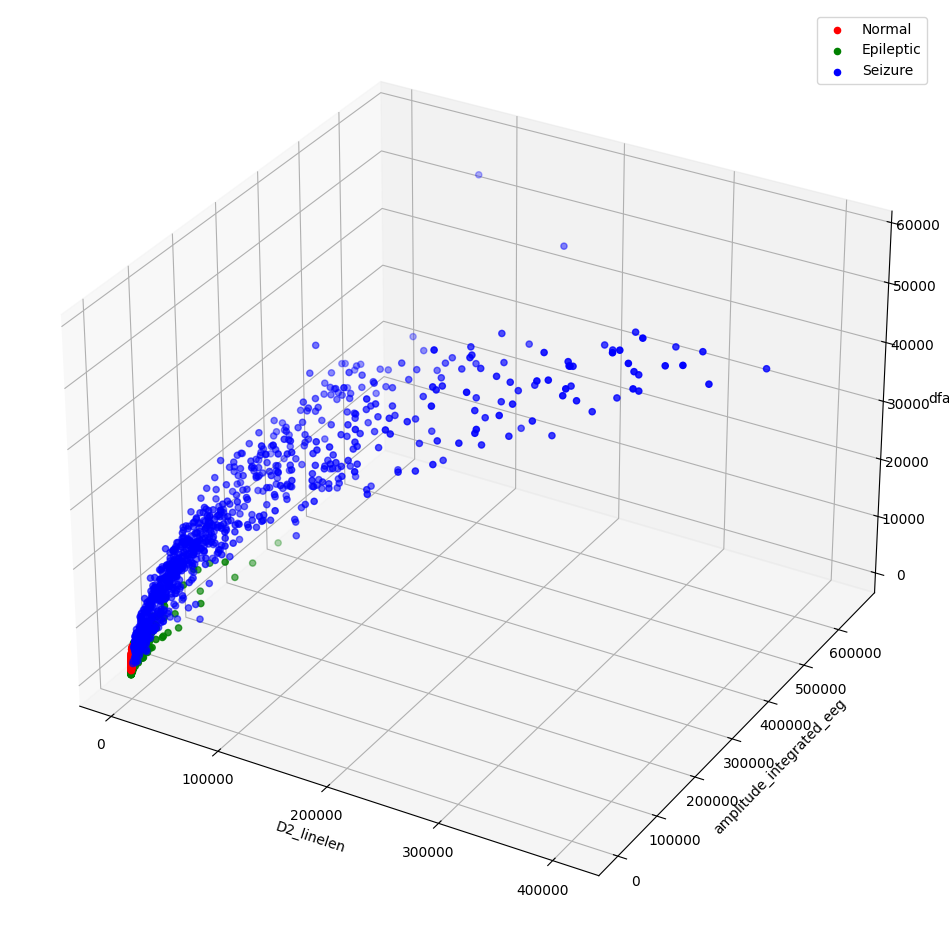

In [ ]:
# Extract columns
spectral_entropy = df['12-30Hz (absolute power)']
peak_freq = df['energy']
additional_feature = df['line_length']  # Replace with the name of the third feature
labels = df['label']  # Assuming your labels are in a column called 'label'

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each class with different colors
ax.scatter(
    spectral_entropy[labels == 0],
    peak_freq[labels == 0],
    additional_feature[labels == 0],
    color='r', label='Normal'
)
ax.scatter(
    spectral_entropy[labels == 1],
    peak_freq[labels == 1],
    additional_feature[labels == 1],
    color='g', label='Epileptic'
)
ax.scatter(
    spectral_entropy[labels == 2],
    peak_freq[labels == 2],
    additional_feature[labels == 2],
    color='b', label='Seizure'
)

# Label axes
ax.set_xlabel('D2_linelen')
ax.set_ylabel('amplitude_integrated_eeg')
ax.set_zlabel('dfa')

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
# Define the machine learning model (in this case, a KNN Classifier)
model = KNeighborsClassifier(n_neighbors=5)  # K set to 5, adjust as needed

X_knn = df[knn_features]
y = df['label']

scaler = StandardScaler()
normalized_features = scaler.fit_transform(X_knn)

# Train the model
model.fit(normalized_features, y)


KNeighborsClassifier()

In [ ]:
# Test and evaluate the model
X_test = pd.read_csv('/content/test_all_features.csv')

x_test = X_test[knn_features]
y_test = X_test['label']

X_test_scaled = scaler.transform(x_test)
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.915
Confusion Matrix:
 [[540  60   0]
 [ 54 527  19]
 [  1  19 580]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90       600
           1       0.87      0.88      0.87       600
           2       0.97      0.97      0.97       600

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800



In [ ]:
# Random forest classifier
from sklearn.ensemble import RandomForestClassifier

X = features
y = df['label']

# Normalize the discriminative metrics
scaler = StandardScaler()
normalized_features = scaler.fit_transform(X)

# Initialize an empty list to store selected feature indices
selected_features = []

# Define the machine learning model (Random Forest Classifier)
model = RandomForestClassifier(random_state=42, n_estimators=100)

# Define the number of features you want to select
num_features_to_select = 3

# Feature Selection Loop
while len(selected_features) < num_features_to_select:
    best_score = -1
    best_feature = None

    for feature_idx in range(normalized_features.shape[1]):
        if feature_idx in selected_features:
            continue

        # Try adding the feature to the selected set
        candidate_features = selected_features + [feature_idx]

        # Evaluate the model's performance using cross-validation
        scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # Keep track of the best-performing feature
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature_idx

    if best_feature is not None:
        selected_features.append(best_feature)
        print(f"Selected Feature {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")

print("Selected feature indices:", selected_features)

Selected Feature 1: 41, Mean Accuracy: 0.7380
Selected Feature 2: 55, Mean Accuracy: 0.9097
Selected Feature 3: 54, Mean Accuracy: 0.9363
Selected feature indices: [41, 55, 54]


In [ ]:
rf_features = []
for idx in selected_features:
    rf_features.append(X.columns[idx])

print(rf_features)

['12-30Hz (absolute power)', 'amplitude_integrated_eeg', 'line_length']


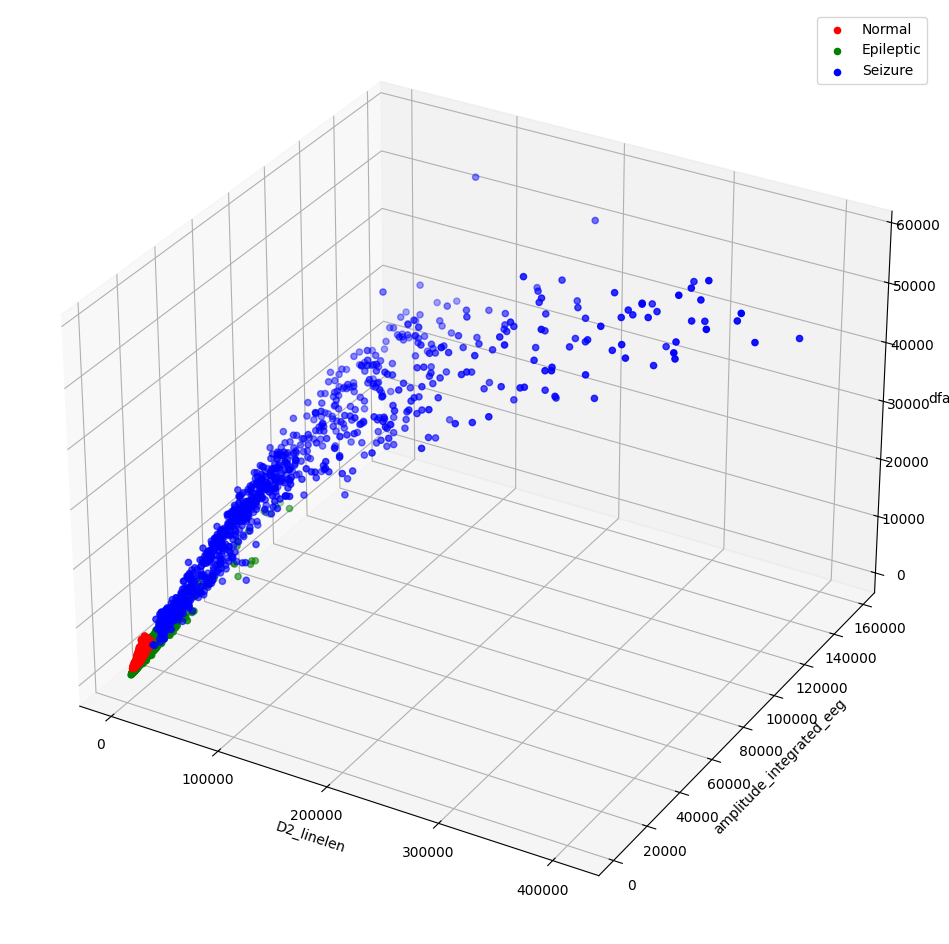

In [ ]:
# Extract columns for 3D scatter plot visualization
spectral_entropy = df['12-30Hz (absolute power)']
peak_freq = df['amplitude_integrated_eeg']
additional_feature = df['line_length']  # Replace with the name of the third feature
labels = df['label']

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each class with different colors
ax.scatter(
    spectral_entropy[labels == 0],
    peak_freq[labels == 0],
    additional_feature[labels == 0],
    color='r', label='Normal'
)
ax.scatter(
    spectral_entropy[labels == 1],
    peak_freq[labels == 1],
    additional_feature[labels == 1],
    color='g', label='Epileptic'
)
ax.scatter(
    spectral_entropy[labels == 2],
    peak_freq[labels == 2],
    additional_feature[labels == 2],
    color='b', label='Seizure'
)

# Label axes
ax.set_xlabel('D2_linelen')
ax.set_ylabel('amplitude_integrated_eeg')
ax.set_zlabel('dfa')

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
# Train the Random Forest model with selected features
X_rf = df[rf_features]
y = df['label']

# Normalize the selected features
normalized_features = scaler.fit_transform(X_rf)

# Train the Random Forest model
model.fit(normalized_features, y)

RandomForestClassifier(random_state=42)

In [ ]:
# Test and evaluate the model
X_test = pd.read_csv('/content/test_all_features.csv')

x_test = X_test[rf_features]
y_test = X_test['label']

X_test_scaled = scaler.transform(x_test)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9405555555555556
Confusion Matrix:
 [[557  43   0]
 [ 30 556  14]
 [  0  20 580]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94       600
           1       0.90      0.93      0.91       600
           2       0.98      0.97      0.97       600

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



In [ ]:
# SVM with linear kernel
from sklearn.svm import SVC

X = features  # Feature matrix
y = df['label']  # Target labels

# Normalize the feature set
scaler = StandardScaler()
normalized_features = scaler.fit_transform(X)

# Initialize an empty list to store selected feature indices
selected_features = []

# Define the machine learning model (SVM Classifier)
model = SVC(kernel='linear')

# Define the number of features to select
num_features_to_select = 3

while len(selected_features) < num_features_to_select:
    best_score = -1
    best_feature = None

    for feature_idx in range(normalized_features.shape[1]):
        if feature_idx in selected_features:
            continue

        # Try adding the feature to the selected set
        candidate_features = selected_features + [feature_idx]

        # Evaluate the model's performance using cross-validation
        scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # Keep track of the best-performing feature
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature_idx

    if best_feature is not None:
        selected_features.append(best_feature)
        print(f"Selected Feature {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")

print("Selected feature indices:", selected_features)

Selected Feature 1: 9, Mean Accuracy: 0.7670
Selected Feature 2: 34, Mean Accuracy: 0.9007


In [ ]:
# Extract selected feature names
svm_features = []
for idx in selected_features:
    svm_features.append(X.columns[idx])

print("Selected Features:", svm_features)

Selected Features: ['A4_linelen', 'spectral_edge_freq', 'line_length']


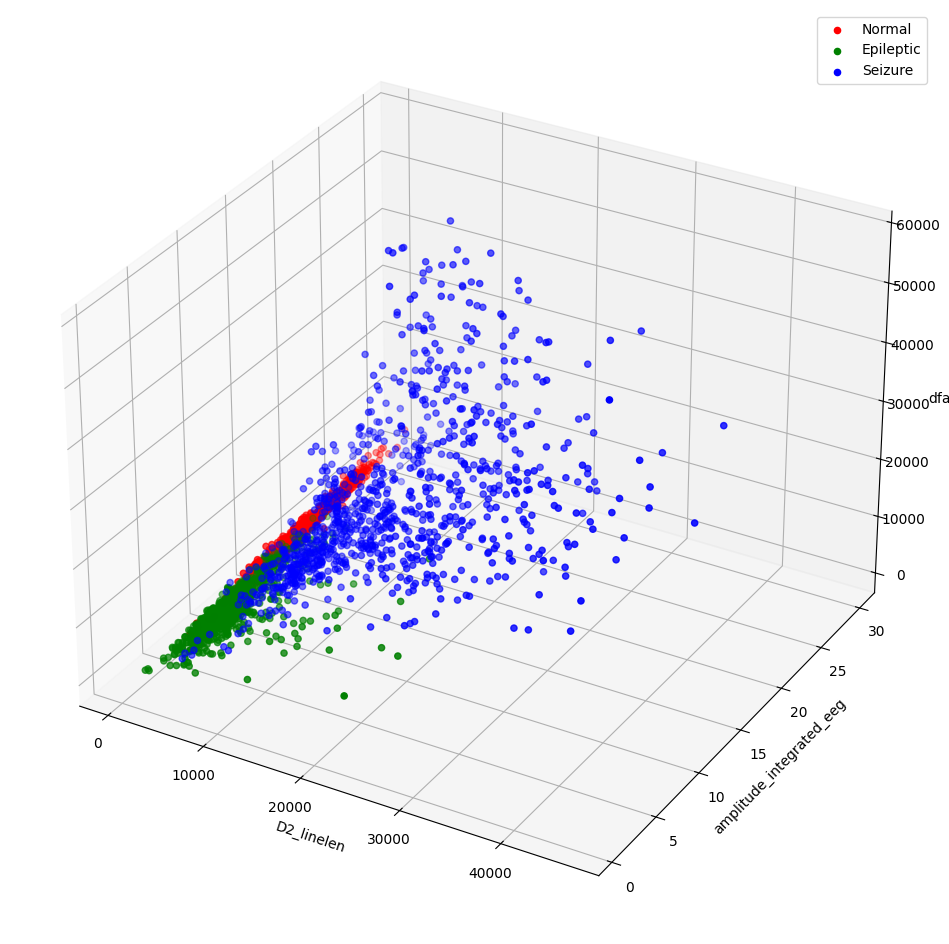

In [ ]:
# 3D Scatter Plot for Visualization
# Extract columns for visualization
spectral_entropy = df['A4_linelen']
peak_freq = df['spectral_edge_freq']
additional_feature = df['line_length']  # Replace with the name of the third feature
labels = df['label']  # Assuming your labels are in a column called 'label'

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each class with different colors
ax.scatter(
    spectral_entropy[labels == 0],
    peak_freq[labels == 0],
    additional_feature[labels == 0],
    color='r', label='Normal'
)
ax.scatter(
    spectral_entropy[labels == 1],
    peak_freq[labels == 1],
    additional_feature[labels == 1],
    color='g', label='Epileptic'
)
ax.scatter(
    spectral_entropy[labels == 2],
    peak_freq[labels == 2],
    additional_feature[labels == 2],
    color='b', label='Seizure'
)

# Label axes
ax.set_xlabel('D2_linelen')
ax.set_ylabel('amplitude_integrated_eeg')
ax.set_zlabel('dfa')

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
# Model Training with Selected Features
X_svm = df[svm_features]
y = df['label']

# Normalize features
normalized_features = scaler.fit_transform(X_svm)

# Train the SVM Classifier
model = SVC(kernel='linear')
model.fit(normalized_features, y)

SVC(kernel='linear')

In [ ]:
# Load the test set
X_test = pd.read_csv('/content/test_all_features.csv')

# Extract test features and labels
x_test = X_test[svm_features]
y_test = X_test['label']

# Normalize test features
X_test_scaled = scaler.transform(x_test)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9261111111111111
Confusion Matrix:
 [[551  49   0]
 [ 47 541  12]
 [  0  25 575]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       600
           1       0.88      0.90      0.89       600
           2       0.98      0.96      0.97       600

    accuracy                           0.93      1800
   macro avg       0.93      0.93      0.93      1800
weighted avg       0.93      0.93      0.93      1800



In [ ]:
# SVM with RBF Kernel

X = features  # Assuming 'features' is our feature matrix
y = df['label']  # Assuming 'label' is our target column

# Normalize the discriminative metrics
scaler = StandardScaler()
normalized_features = scaler.fit_transform(X)

# Initialize an empty list to store selected feature indices
selected_features = []

# Define the machine learning model (SVM with RBF kernel)
model = SVC(kernel='rbf', gamma='scale', C=1)

# Define the number of features you want to select
num_features_to_select = 3

while len(selected_features) < num_features_to_select:
    best_score = -1
    best_feature = None

    for feature_idx in range(normalized_features.shape[1]):
        if feature_idx in selected_features:
            continue

        # Try adding the feature to the selected set
        candidate_features = selected_features + [feature_idx]

        # Evaluate the model's performance using cross-validation
        scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # Keep track of the best-performing feature
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature_idx

    if best_feature is not None:
        selected_features.append(best_feature)
        print(f"Selected Feature {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")

print("Selected feature indices:", selected_features)

Selected Feature 1: 9, Mean Accuracy: 0.7710
Selected Feature 2: 54, Mean Accuracy: 0.9050
Selected Feature 3: 34, Mean Accuracy: 0.9240
Selected feature indices: [9, 54, 34]


In [ ]:
# Get names of the selected features
svm_with_rbf_features = []
for idx in selected_features:
    svm_with_rbf_features.append(X.columns[idx])

print("Selected Features:", svm_with_rbf_features)

Selected Features: ['A4_linelen', 'line_length', 'spectral_edge_freq']


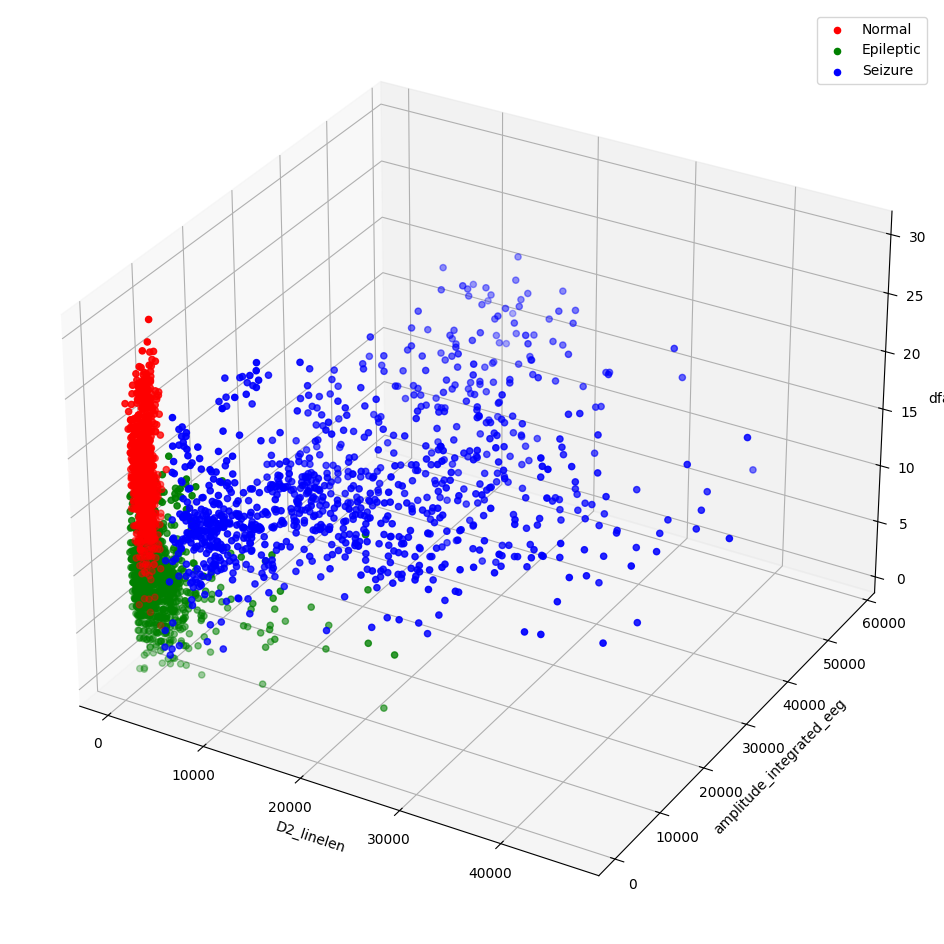

In [ ]:
# Visualization (3D Scatter Plot)
spectral_entropy = df['A4_linelen']
peak_freq = df['line_length']
additional_feature = df['spectral_edge_freq']  # Replace with the name of the third feature
labels = df['label']

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each class with different colors
ax.scatter(
    spectral_entropy[labels == 0],
    peak_freq[labels == 0],
    additional_feature[labels == 0],
    color='r', label='Normal'
)
ax.scatter(
    spectral_entropy[labels == 1],
    peak_freq[labels == 1],
    additional_feature[labels == 1],
    color='g', label='Epileptic'
)
ax.scatter(
    spectral_entropy[labels == 2],
    peak_freq[labels == 2],
    additional_feature[labels == 2],
    color='b', label='Seizure'
)

# Label axes
ax.set_xlabel('D2_linelen')
ax.set_ylabel('amplitude_integrated_eeg')
ax.set_zlabel('dfa')

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
# Train SVM with the selected features
X_svm = df[svm_with_rbf_features]
y = df['label']

normalized_features = scaler.fit_transform(X_svm)
model = SVC(kernel='rbf', gamma='scale', C=1)

model.fit(normalized_features, y)


SVC(C=1)

In [ ]:
# Testing and Evaluation
X_test = pd.read_csv('/content/test_all_features.csv')
x_test = X_test[svm_with_rbf_features]
y_test = X_test['label']

X_test_scaled = scaler.transform(x_test)
y_pred = model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9233333333333333
Confusion Matrix:
 [[561  39   0]
 [ 60 529  11]
 [  3  25 572]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       600
           1       0.89      0.88      0.89       600
           2       0.98      0.95      0.97       600

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800



In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

remaining_features = df.drop('label', axis=1)
remaining_features = remaining_features.drop(logreg_features, axis=1)
y_remaining = df['label']

# Initialize an empty list to store selected feature indices
selected_features = []

# Define the machine learning model (in this case, a Random Forest Classifier)
qda = QuadraticDiscriminantAnalysis()
# qda.fit(remaining_features, y)

# Define the number of features you want to select
num_features_to_select = 3

while len(selected_features) < num_features_to_select:
    best_score = -1
    best_feature = None

    for feature_idx in range(remaining_features.shape[1]):
        if feature_idx in selected_features:
            continue

        # Try adding the feature to the selected set
        candidate_features = selected_features + [feature_idx]

        # Evaluate the model's performance using cross-validation
        scores = cross_val_score(qda, remaining_features.iloc[:, candidate_features], y, cv=5, scoring='accuracy')
        mean_score = np.mean(scores)

        # Keep track of the best-performing feature
        if mean_score > best_score:
            best_score = mean_score
            best_feature = feature_idx

    if best_feature is not None:
        selected_features.append(best_feature)
        print(f"Selected Feature {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")

print("Selected feature indices:", selected_features)



Selected Feature 1: 24, Mean Accuracy: 0.7353
Selected Feature 2: 72, Mean Accuracy: 0.9090
Selected Feature 3: 74, Mean Accuracy: 0.9173
Selected feature indices: [24, 72, 74]


In [ ]:
qda_features = []
for idx in selected_features:
  qda_features.append(remaining_features.columns[idx])

print(qda_features)

['D3_std', 'hjorth_mobility', 'dfa']


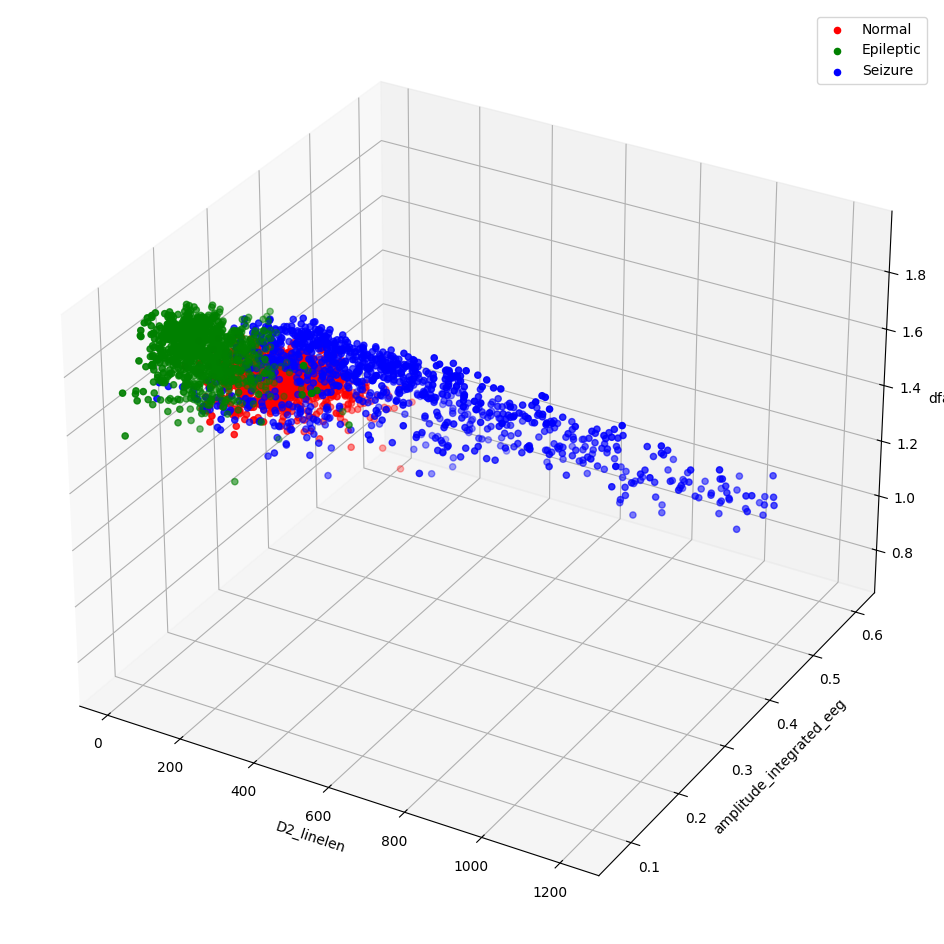

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Extract columns
spectral_entropy = df['D3_std']
peak_freq = df['hjorth_mobility']
additional_feature = df['dfa']  # Replace with the name of the third feature
labels = df['label']  # Assuming your labels are in a column called 'label'

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot points for each class with different colors
ax.scatter(
    spectral_entropy[labels == 0],
    peak_freq[labels == 0],
    additional_feature[labels == 0],
    color='r', label='Normal'
)
ax.scatter(
    spectral_entropy[labels == 1],
    peak_freq[labels == 1],
    additional_feature[labels == 1],
    color='g', label='Epileptic'
)
ax.scatter(
    spectral_entropy[labels == 2],
    peak_freq[labels == 2],
    additional_feature[labels == 2],
    color='b', label='Seizure'
)

# Label axes
ax.set_xlabel('D2_linelen')
ax.set_ylabel('amplitude_integrated_eeg')
ax.set_zlabel('dfa')

# Add legend
ax.legend()

# Show plot
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [ ]:
class FeatureEnsembleClassifier:
    def __init__(self, data, model_list, feature_subset):
        self.model_list = model_list
        self.feature_subset = feature_subset
        self.selected_features = []
        self.trained_models = []
        self.accurracies = []
        self.data = data

    def check_error(self):
      if(len(self.model_list) != len(self.feature_subset)):
        raise IndexError("Encountered an extra feature subset or model.")


    def fit(self):
        for i in range(len(self.model_list)):
          if self.model_list[i] == 'logreg':
            logreg_features = self.logreg_feature(self.feature_subset[i])
            logreg = self.fit_logreg(logreg_features)
            self.trained_models.append(logreg)
            self.selected_features.append(logreg_features)
            self.data = self.data.drop(columns = logreg_features, axis=1)

          elif self.model_list[i] == 'knn':
            knn_features = self.knn_feature(self.feature_subset[i])
            knn = self.fit_knn(knn_features)
            self.trained_models.append(knn)
            self.selected_features.append(knn_features)
            self.data = self.data.drop(columns = knn_features, axis=1)

          elif self.model_list[i] == 'rf':
            rf_features = self.rf_feature(self.feature_subset[i])
            rf = self.fit_rf(rf_features)
            self.trained_models.append(rf)
            self.selected_features.append(rf_features)
            self.data = self.data.drop(columns = rf_features, axis=1)

          elif self.model_list[i] == 'svm':
            svm_features = self.svm_feature(self.feature_subset[i])
            svm = self.fit_svm(svm_features)
            self.trained_models.append(svm)
            self.selected_features.append(svm_features)
            self.data = self.data.drop(columns = svm_features, axis=1)

          elif self.model_list[i] == 'svm_with_rbf':
            svm_with_rbf_features = self.svm_with_rbf_feature(self.feature_subset[i])
            svm_with_rbf = self.fit_svm_with_rbf(svm_with_rbf_features)
            self.trained_models.append(svm_with_rbf)
            self.selected_features.append(svm_with_rbf_features)
            self.data = self.data.drop(columns = svm_with_rbf_features, axis=1)

          elif self.model_list[i] == 'gda':
            gda_features = self.gda_feature(self.feature_subset[i])
            gda = self.fit_gda(gda_features)
            self.trained_models.append(gda)
            self.selected_features.append(gda_features)
            self.data = self.data.drop(columns = gda_features, axis=1)
          elif self.model_list[i] == 'lda':
            lda_features = self.gda_feature(self.feature_subset[i])
            lda = self.fit_gda(lda_features)
            self.trained_models.append(lda)
            self.selected_features.append(lda_features)
            self.data = self.data.drop(columns = lda_features, axis=1)

          else:
            raise ValueError("Invalid model name")

    def logreg_feature(self, features):
        """
        A class method that acts on the class itself.

        Args:
            param (type): Description of param.

        Returns:
            MyClass: Returns an instance of the class.
        """
        X = self.data.drop('label', axis=1)
        y = self.data['label']

        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(X)
        model = LogisticRegression()

        selected_features = []
        num_features_to_select = features

        while len(selected_features) < num_features_to_select:
            best_score = -1
            best_feature = None

            for feature_idx in range(normalized_features.shape[1]):
                if feature_idx in selected_features:
                    continue

                # Try adding the feature to the selected set
                candidate_features = selected_features + [feature_idx]

                # Evaluate the model's performance using cross-validation
                scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
                mean_score = np.mean(scores)

                # Keep track of the best-performing feature
                if mean_score > best_score:
                    best_score = mean_score
                    best_feature = feature_idx

            if best_feature is not None:
                selected_features.append(best_feature)
                self.accurracies.append(best_score)
                print(f"Selected Features for logistic regression {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")


        logreg_features = []
        for idx in selected_features:
          logreg_features.append(X.columns[idx])

        print(logreg_features)
        return logreg_features


    def knn_feature(self, features):
        """
        A class method that acts on the class itself.

        Args:
            param (type): Description of param.

        Returns:
            MyClass: Returns an instance of the class.
        """
        X = self.data.drop('label', axis=1)
        y = self.data['label']

        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(X)
        model = KNeighborsClassifier(n_neighbors=5)

        selected_features = []
        num_features_to_select = features

        while len(selected_features) < num_features_to_select:
            best_score = -1
            best_feature = None

            for feature_idx in range(normalized_features.shape[1]):
                if feature_idx in selected_features:
                    continue

                # Try adding the feature to the selected set
                candidate_features = selected_features + [feature_idx]

                # Evaluate the model's performance using cross-validation
                scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
                mean_score = np.mean(scores)

                # Keep track of the best-performing feature
                if mean_score > best_score:
                    best_score = mean_score
                    best_feature = feature_idx

            if best_feature is not None:
                selected_features.append(best_feature)
                self.accurracies.append(best_score)
                print(f"Selected Features for KNN {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")


        knn_features = []
        for idx in selected_features:
          knn_features.append(X.columns[idx])

        print(knn_features)
        return knn_features


    def rf_feature(self, features):
        """
        A class method that acts on the class itself.

        Args:
            param (type): Description of param.

        Returns:
            MyClass: Returns an instance of the class.
        """
        X = self.data.drop('label', axis=1)
        y = self.data['label']

        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(X)
        model = RandomForestClassifier(random_state=42, n_estimators=100)

        selected_features = []
        num_features_to_select = features

        while len(selected_features) < num_features_to_select:
            best_score = -1
            best_feature = None

            for feature_idx in range(normalized_features.shape[1]):
                if feature_idx in selected_features:
                    continue

                # Try adding the feature to the selected set
                candidate_features = selected_features + [feature_idx]

                # Evaluate the model's performance using cross-validation
                scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
                mean_score = np.mean(scores)

                # Keep track of the best-performing feature
                if mean_score > best_score:
                    best_score = mean_score
                    best_feature = feature_idx

            if best_feature is not None:
                selected_features.append(best_feature)
                self.accurracies.append(best_score)
                print(f"Selected Features for Random forest {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")


        rf_features = []
        for idx in selected_features:
          rf_features.append(X.columns[idx])

        print(rf_features)
        return rf_features


    def svm_feature(self, features):
        """
        A class method that acts on the class itself.

        Args:
            param (type): Description of param.

        Returns:
            MyClass: Returns an instance of the class.
        """
        X = self.data.drop('label', axis=1)
        y = self.data['label']

        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(X)
        model = SVC(kernel='linear')

        selected_features = []
        num_features_to_select = features

        while len(selected_features) < num_features_to_select:
            best_score = -1
            best_feature = None

            for feature_idx in range(normalized_features.shape[1]):
                if feature_idx in selected_features:
                    continue

                # Try adding the feature to the selected set
                candidate_features = selected_features + [feature_idx]

                # Evaluate the model's performance using cross-validation
                scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
                mean_score = np.mean(scores)

                # Keep track of the best-performing feature
                if mean_score > best_score:
                    best_score = mean_score
                    best_feature = feature_idx

            if best_feature is not None:
                selected_features.append(best_feature)
                self.accurracies.append(best_score)
                print(f"Selected Features for SVM {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")


        svm_features = []
        for idx in selected_features:
          svm_features.append(X.columns[idx])

        print(svm_features)
        return svm_features


    def svm_with_rbf_feature(self, features):
        """
        A class method that acts on the class itself.

        Args:
            param (type): Description of param.

        Returns:
            MyClass: Returns an instance of the class.
        """
        X = self.data.drop('label', axis=1)
        y = self.data['label']

        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(X)
        model = SVC(kernel='rbf', gamma='scale', C=1)

        selected_features = []
        num_features_to_select = features

        while len(selected_features) < num_features_to_select:
            best_score = -1
            best_feature = None

            for feature_idx in range(normalized_features.shape[1]):
                if feature_idx in selected_features:
                    continue

                # Try adding the feature to the selected set
                candidate_features = selected_features + [feature_idx]

                # Evaluate the model's performance using cross-validation
                scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
                mean_score = np.mean(scores)

                # Keep track of the best-performing feature
                if mean_score > best_score:
                    best_score = mean_score
                    best_feature = feature_idx

            if best_feature is not None:
                selected_features.append(best_feature)
                self.accurracies.append(best_score)
                print(f"Selected Features for SVM with RBF Kernel {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")


        svm_with_rbf_features = []
        for idx in selected_features:
          svm_with_rbf_features.append(X.columns[idx])

        print(svm_with_rbf_features)
        return svm_with_rbf_features


    def lda_feature(self, features):
        """
        A class method that acts on the class itself.

        Args:
            param (type): Description of param.

        Returns:
            MyClass: Returns an instance of the class.
        """
        X = self.data.drop('label', axis=1)
        y = self.data['label']
        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(X)
        model = QuadraticDiscriminantAnalysis()

        selected_features = []
        num_features_to_select = features

        while len(selected_features) < num_features_to_select:
            best_score = -1
            best_feature = None

            for feature_idx in range(normalized_features.shape[1]):
                if feature_idx in selected_features:
                    continue

                # Try adding the feature to the selected set
                candidate_features = selected_features + [feature_idx]

                # Evaluate the model's performance using cross-validation
                scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
                mean_score = np.mean(scores)

                # Keep track of the best-performing feature
                if mean_score > best_score:
                    best_score = mean_score
                    best_feature = feature_idx

            if best_feature is not None:
                selected_features.append(best_feature)
                self.accurracies.append(best_score)
                print(f"Selected Features for LDA {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")


        lda_features = []
        for idx in selected_features:
          lda_features.append(X.columns[idx])

        print(lda_features)
        return lda_features

    def gda_feature(self, features):
        """
        A class method that acts on the class itself.

        Args:
            param (type): Description of param.

        Returns:
            MyClass: Returns an instance of the class.
        """
        X = self.data.drop('label', axis=1)
        y = self.data['label']

        scaler = StandardScaler()
        normalized_features = scaler.fit_transform(X)
        model = QuadraticDiscriminantAnalysis()

        selected_features = []
        num_features_to_select = features

        while len(selected_features) < num_features_to_select:
            best_score = -1
            best_feature = None

            for feature_idx in range(normalized_features.shape[1]):
                if feature_idx in selected_features:
                    continue

                # Try adding the feature to the selected set
                candidate_features = selected_features + [feature_idx]

                # Evaluate the model's performance using cross-validation
                scores = cross_val_score(model, normalized_features[:, candidate_features], y, cv=5, scoring='accuracy')
                mean_score = np.mean(scores)

                # Keep track of the best-performing feature
                if mean_score > best_score:
                    best_score = mean_score
                    best_feature = feature_idx

            if best_feature is not None:
                selected_features.append(best_feature)
                self.accurracies.append(best_score)
                print(f"Selected Features for GDA {len(selected_features)}: {best_feature}, Mean Accuracy: {best_score:.4f}")


        gda_features = []
        for idx in selected_features:
          gda_features.append(X.columns[idx])

        print(gda_features)
        return gda_features



    def fit_logreg(self, features):
      # Define the machine learning model (in this case, a Random Forest Classifier)
      X = self.data[features]
      y = self.data['label']
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(X)
      # Define the machine learning model (in this case, a Random Forest Classifier)
      model = LogisticRegression()

      model.fit(normalized_features, y)

      return model


    def fit_knn(self, features):
      X = self.data[features]
      y = self.data['label']
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(X)
      model = KNeighborsClassifier(n_neighbors=5)
      model.fit(normalized_features, y)
      return model


    def fit_rf(self, features):
      X = self.data[features]
      y = self.data['label']
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(X)
      model = RandomForestClassifier(random_state=42, n_estimators=100)
      model.fit(normalized_features, y)
      return model

    def fit_svm(self, features):
      X = self.data[features]
      y = self.data['label']
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(X)
      model = SVC(kernel='linear')
      model.fit(normalized_features, y)
      return model


    def fit_svm_with_rbf(self, features):
      X = self.data[features]
      y = self.data['label']
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(X)
      model = SVC(kernel='rbf', gamma='scale', C=1)
      model.fit(normalized_features, y)
      return model


    def fit_gda(self, features):
      X = self.data[features]
      y = self.data['label']
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(X)
      model = QuadraticDiscriminantAnalysis()
      model.fit(normalized_features, y)
      return model

    def fit_lda(self, features):
      X = self.data[features]
      y = self.data['label']
      scaler = StandardScaler()
      normalized_features = scaler.fit_transform(X)
      model = LinearDiscriminantAnalysis()
      model.fit(normalized_features, y)
      return model



    def predict(self, data):
        predictions = []
        for i in range(len(self.trained_models)):
          print(f"Evaluating {self.model_list[i]}")
          model = self.trained_models[i]
          features = self.selected_features[i]
          X = data[features]
          y_test = data['label']
          scaler = StandardScaler()
          normalized_features = scaler.fit_transform(X)
          y_pred = model.predict(normalized_features)
          predictions.append(y_pred)
          # Calculate accuracy
          accuracy = accuracy_score(y_test, y_pred)
          print("Accuracy:", accuracy)
          # Display confusion matrix
          conf_matrix = confusion_matrix(y_test, y_pred)
          print("Confusion Matrix:\n", conf_matrix)
          # Display classification report
          print("Classification Report:\n", classification_report(y_test, y_pred))


In [ ]:
# Example usage
if __name__ == "__main__":
    # Create an instance of the class
    classifier = FeatureEnsembleClassifier(data, model_list = ["logreg", "knn", "rf", "svm", "svm_with_rbf", "gda", "lda"], feature_subset = [3, 3, 6, 3, 3, 3, 3])

    X_test = pd.read_csv('/content/test_all_features.csv')
    features = X_test[selected_features]
    label_column = X_test['label']

    test = pd.concat([features, label_column], axis=1)

    classifier.fit()
    classifier.predict(test)

Selected Features for logistic regression 1: 9, Mean Accuracy: 0.7633
Selected Features for logistic regression 2: 34, Mean Accuracy: 0.8993
Selected Features for logistic regression 3: 54, Mean Accuracy: 0.9187
['A4_linelen', 'spectral_edge_freq', 'line_length']
Selected Features for KNN 1: 39, Mean Accuracy: 0.7720
Selected Features for KNN 2: 30, Mean Accuracy: 0.9070
Selected Features for KNN 3: 42, Mean Accuracy: 0.9167
['12-30Hz (absolute power)', 'energy', 'variance']
Selected Features for Random forest 1: 50, Mean Accuracy: 0.7070
Selected Features for Random forest 2: 52, Mean Accuracy: 0.9190
Selected Features for Random forest 3: 13, Mean Accuracy: 0.9340
Selected Features for Random forest 4: 37, Mean Accuracy: 0.9393
Selected Features for Random forest 5: 16, Mean Accuracy: 0.9457
Selected Features for Random forest 6: 33, Mean Accuracy: 0.9463
['nonlinear_energy', 'hjorth_activity', 'D4_entropy', '8-12Hz (absolute power)', 'D4_skewness', 'peak_freq']
Selected Features for

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Selected Features for GDA 2: 25, Mean Accuracy: 0.8407
Selected Features for GDA 3: 8, Mean Accuracy: 0.8627
['rms', 'spectral_entropy', 'A4_kurtosis']
Evaluating logreg
Accuracy: 0.925


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


NameError: name 'confusion_matrix' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

classifier.predict(test)

Evaluating logreg
Accuracy: 0.925
Confusion Matrix:
 [[564  36   0]
 [ 59 526  15]
 [  4  21 575]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       600
           1       0.90      0.88      0.89       600
           2       0.97      0.96      0.97       600

    accuracy                           0.93      1800
   macro avg       0.93      0.92      0.92      1800
weighted avg       0.93      0.93      0.92      1800

Evaluating knn
Accuracy: 0.72
Confusion Matrix:
 [[597   3   0]
 [436 103  61]
 [  0   4 596]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.99      0.73       600
           1       0.94      0.17      0.29       600
           2       0.91      0.99      0.95       600

    accuracy                           0.72      1800
   macro avg       0.81      0.72      0.66      1800
weighted avg       0.81      0.72      0.66      18